Andrea Morelli 1845525 4 th Homework Big Data

In [ ]:
#the latest sklearn version is needed for the inverse of the random projection
!pip install -U scikit-learn==1.2.0

Those are the functions that allow to read the dataset , create wordcloud starting from keywords , do the elbow method both for the svd and for the k means and apply svd and k means.

In [ ]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from IPython.display import clear_output
import re
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import random_projection
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn
print(sklearn.__version__)
randomProjected=False

#read the dataset and randomly seelct part of it if you want to take just a part of it
def readDataset(percentage=0.1):
    global vectorizer
    global randomProjected
    #read X from a file
    with open('X.pickle', 'rb') as f:
        X = pickle.load(f)
    #read the vectorizer from a file
    with open('vectorizer.pickle', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names=vectorizer.get_feature_names_out(input_features=X)
    #take just a percantage of it for testing
    np.random_state=42
    rowsToRetain=int(X.shape[0]*percentage)
    X=X[np.random.choice(X.shape[0], rowsToRetain, replace=False)]
    randomProjected=False
    return X

def createWordCloud(keywords):
    # Create the wordcloud object
    wordcloud = WordCloud().generate(' '.join(keywords))
    # Display the generated wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#does the elbow method with the k means starting from min to max with step and plot the inertias for each k 
def elbowMethodMiniBatchKMeans(X,min=1,max=40,step=2,batch_size=1000):
    k=range(min,max,step)
    inertias=[]
    for i in k:
        if batch_size==0:
            km=KMeans(n_clusters=i,init='k-means++')
        else:
            km=MiniBatchKMeans(n_clusters=i,init='k-means++',batch_size=batch_size)
        km.fit(X)
        clear_output(wait=True)
        print(i,km.inertia_)
        inertias.append(km.inertia_)
        plt.plot(range(1,i+1,step),inertias,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('inertias')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()
        
#does the elbow method with the svd starting from min to max with step and plot the energies for each k
def elbowMethodSvd(X,min=1,max=40,step=2):
    #elbow methood on the svds
    k=range(min,max,step)
    energies=[]
    for i in k:
        svd=TruncatedSVD(n_components=i)
        svd.fit(X)
        energies.append(svd.explained_variance_ratio_.sum())
        #plot the results up to this point
        clear_output(wait=True)
        print(i,svd.explained_variance_ratio_.sum())
        plt.plot(range(1,i+1,step),energies,'-o')
        plt.xlabel('number of clusters, k')
        plt.ylabel('energy')
        # plt.xticks(k[:i])
        plt.show()
        plt.clf()

#applis the kmeans algorithm with k clusters and prints the top 20 words of each cluster, if batchsize is 0 then it uses the normal k means otherwise minibatch k means
def miniBatchKMeans(X,k=20,batch_size=1000,X_proj=None):
    global randomProjected,rp
    if batch_size==0:
        km=KMeans(n_clusters=k,init='k-means++')
    else:
        km = MiniBatchKMeans(n_clusters=k, init='k-means++',batch_size=batch_size)
    if randomProjected:
        km.fit(X_proj)
        centroids=[]
        for i in range(k):
            centroids.append(X[km.labels_==i].mean(axis=0))
        centroids=np.array(centroids)
    else:
        km.fit(X)
        centroids=km.cluster_centers_
    centroids=centroids.squeeze()
    centroids = centroids.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
    terms = vectorizer.get_feature_names_out()
    centroids=centroids.squeeze()
    for i in range(k):
        print("Cluster %d:" % i, end='')
        keywords=[]
        for ind in centroids[i, :20]:
            print(' %s' % terms[ind], end='')
            keywords.append(terms[ind])
        createWordCloud(keywords)
        print()

#applis the svd algorithm with k clusters (dimensions) and prints the top 20 words of each cluster
def truncatedSVD(X,k=20,X_proj=None):
    global randomProjected,rp
    svd = TruncatedSVD(n_components=k ,random_state=42)
    if randomProjected:
        y=svd.fit_transform(X_proj)
        components=rp.inverse_transform(svd.components_)
    else:
        y=svd.fit_transform(X)
        components=svd.components_
    print(f"Total energy retained in ratio: {svd.explained_variance_ratio_.sum()}")
    terms = vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Topic "+str(i)+": ")
        createWordCloud(i[0] for i in sorted_terms)
        s = ""
        for t in sorted_terms:
            s += t[0] + " "
        print(s)
    

connect to google drive to retrieve the preprocessed data not doing it from scratch everytime

In [ ]:
from google.colab import drive
drive.mount('/drive')

In [ ]:
%cd ../drive/My Drive/bigdatahw4

download the kaggle dataset to google drive

In [ ]:
#insert the kaggle json file in the content directory before running this cell
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

In [ ]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-books-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

read the dataset or just a portion for testing purposes

In [ ]:

percentage=1
nRows=3000001
nOfRowsToRead=int(nRows*percentage)

#read the csv text file
df = pd.read_csv('./Books_rating.csv', header=None , nrows=nOfRowsToRead)
df=df.to_numpy()

#split the data into header and data and reviews
header= df[0]
data=df[1:]
docs=data[:,-1]

print(docs.shape)

In [ ]:
#drop nan from the rows to not have problems
toDrop=[i for i,d in enumerate(docs) if type(docs[i])!=str]
docs=np.delete(docs,toDrop)

preprocess the data with tfidfVectorizer after appling lowercase, removing non alphabetic characters, removing stopwords and lemmatizing

In [ ]:
#lowercase the reviews
for i in range(len(docs)):
  docs[i] = docs[i].lower()

print("lowercase done")

#remove non alphabetic characters
for i in range(len(docs)):
  docs[i] = re.sub(r"[^a-zA-Z'\n ]", "", docs[i])

print("remove non alphabetic characters done")

#remove contractions
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

# Regular expression for finding contractions
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

docs = [multiple_replace(contractions_dict, doc) for doc in docs] # Removing contractions

print("contractions done")

#remove \n
docs = [re.sub(r"[^a-zA-Z ]", " ", doc) for doc in docs]

#remove stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

stopwords = nltk.corpus.stopwords.words('english') # Returns a list
stopwords = set(stopwords) # We want a set, because this is implemented with a hash table
                           # Checking the if condition in rem_stop costs O(1) in this way

def rem_stop(doc):
   word_list = word_tokenize(doc)
   cleaned_doc = ""
   for word in word_list:
     if word not in stopwords:
       cleaned_doc += " " + word
   return cleaned_doc


docs = [rem_stop(doc) for doc in docs]

print("stopwords done")

#lemmatiation
lemmatizer = WordNetLemmatizer()
for i in range(len(docs)):
    word_list = word_tokenize(docs[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    docs[i] = lemmatized_doc  

print("lemmetizer done")

#tfidf vectorization
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5) ## Corpus is in English
X = vectorizer.fit_transform(docs)

print("vectorizer done")

print(X.shape)

writes the preprocessed data to the drive

In [ ]:
# write X to a file
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)
#save the fitted vectorizer to not redo the preprocessing again
with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

use the elbow method to a portion of the dataset to find the best number of k

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodMiniBatchKMeans(X,1,40,2,1000)

this is the results using min 1 max 200 and step 20 with batchsize 30000 if you dont want to run the above cell
the elbow is not that clear as one can see but the inertias go down in a faster way in the first 25 inertias

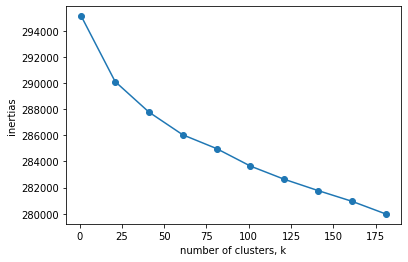

use the elbow method to a portion of the dataset to find the best number of k with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodMiniBatchKMeans(X_proj,1,40,2,1000)

this is the elbow method with random projections and k means with min 1 max 200 and step 20 if you dont want to run the above cell. we can see a sort of elbow


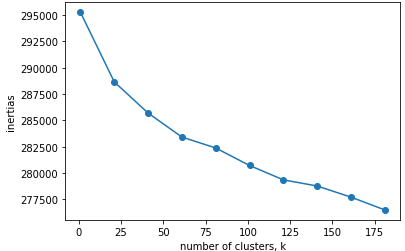

use the elbow method to a portion of the dataset to find the best k with the svd

In [ ]:
X=readDataset(0.1)

In [ ]:
elbowMethodSvd(X,1,40,2)

this the result of the elbow method with svd using min 1 max 500 and step size of 50
as you can see the the elbow is not that pronounced but the retrieved energy increases a lot in the first 50 components

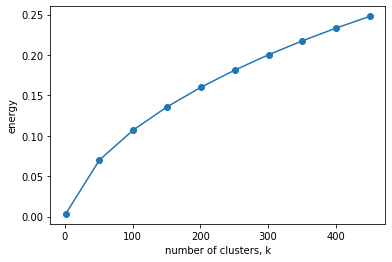

use the elbow method to a portion of the dataset to find the best k with the svd with random projections

In [ ]:
X=readDataset(0.1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
elbowMethodSvd(X_proj,1,40,2)

the result of the elbow method with svd and random projections using min 1 max 500 and step size of 50
50 percent of the energy in this case is conserved in the first 50 components. The elbow in this case is not that clear.

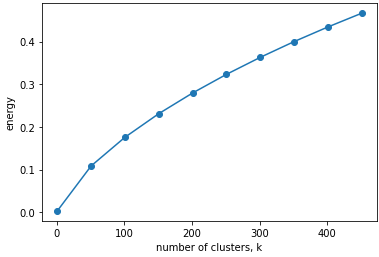

Below i will apply k means and svd on the dataset both normally or using random projections before.
The k means algorithm allows to see better clusters with clear keywords and outperforms the svd algorithm for clustering.
Below you can modify the number of clusters or components and see the results with wordclouds.

apply minibatch k means 

In [ ]:
X=readDataset(1)

In [ ]:
miniBatchKMeans(X,20,1000)

apply truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
truncatedSVD(X,20)

Here you can use the random projeciton before applying the clustering algorithms. The results are not that different from the ones above in fact the k means outperforms the svd algorithm.
The performances are slightly better than the ones obtained without the random projection in the case of the k means. The performances of the svd with random projections though are worse than the ones without random projections.
I suppose that for the k means the random projection acts as a denoiser and the clusters are more clear and separated.
You can change the number of clusters i tried different numbers and with 100 i would obtain more clear keywords seeing clearly types of cluseters.
Using smaller numbers will results in more general keywords and the clusters would not be that visible.
The elbow methods were not super clear on what the number of clusters would be since there was not a pronounced elbow.

apply random projection and then k means

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
miniBatchKMeans(X,20,30000,X_proj)

apply random projection and then truncated svd

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=600)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
truncatedSVD(X,20,X_proj)

apply svd and then k means (results are horrible its there just because i used it and saw that nothing would come out of it)
its probabily because the svd is not able to keep most of the energy in the first components like for example in the images where most of the energy 90% is kept
at the first like 100 components.
In this case with 500 components i would retrieve only the 30% of the energy and it's not enought to cluster the data correctly

In [ ]:
X=readDataset(0.01)

In [ ]:
#apply svd to do dimensionality reduction and then k means to classify the data
newDimensions=200
k=20
batchSize=1000
svd=TruncatedSVD(n_components=newDimensions)
X=svd.fit_transform(X)
if batchSize==0:
    km=KMeans(n_clusters=k,init='k-means++')
else:
    km=MiniBatchKMeans(n_clusters=k,batch_size=batchSize,init='k-means++')
km.fit(X)
centroids=km.cluster_centers_
centroids=svd.inverse_transform(centroids).astype(int)
terms = vectorizer.get_feature_names_out()
for i, comp in enumerate(centroids):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    createWordCloud(i[0] for i in sorted_terms)
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)


The best performances are reached using random projection and the the k means algorithm. 
The random projection acts as noise reduction reducing the dimensionality of the dataset and the k means algorithm is able to find the clusters.
Using 100 or 200 clusters we can clearly see the topics of the reviews in a fine way using less of them would allow to see more general topics like 30.
The performaces are worse if we use less components of the random projection and a smaller batch size.
Using less clusters will allow to see more general topics while using more clusters allows to see for example keywords of the reviews and the books.
Another particularity found is that using just on a portion of the dataset the clustering will allow to see more less general topics while using the whole dataset will allow to see more general topics.

In [ ]:
X=readDataset(1)

In [ ]:
rp=random_projection.SparseRandomProjection(n_components=1000)
X_proj=rp.fit_transform(X)
randomProjected=True

In [ ]:
miniBatchKMeans(X,200,500000,X_proj)

in case you dont want to execute the code i will include the clusters found. the keywords are from most to less important.

Cluster 0: incredible que la book en el read libro los una para lo este story se por como su del time


Cluster 1: book read great reading like best time recommend love written year author loved page easy know want character way interesting


Cluster 2: story book read character love great time like reading life short novel make author good written people reader way child


Cluster 3: purchased book read copy gift photoshop great year time reading love friend good condition daughter new recommend amazon child class


Cluster 4: really book read like enjoyed great reading story character time liked love good know thing recommend think way lot people


Cluster 5: scene book read character story novel verne like time great love taken author life reader make way good really page


Cluster 6: movie book read story time like great reading love character better seen novel good saw loved version make year really


Cluster 7: money book waste read worth time save buy like make good great author people want reading really way lot know


Cluster 8: dictionary word book english use definition language read great reference good need student like entry used spanish useful term look


Cluster 9: hawthorne hester scarlet letter puritan dimmesdale book prynne nathaniel sin novel read pearl story adultery character time reader classic guilt


Cluster 10: book meet read tony plus morris tour story anthology like saying great dish time character love life make reading author


Cluster 11: bird wolfe book courage edna ruth flat read story character life like time novel love great nero good reading woman


Cluster 12: hemingway concept religion book read story like great time novel life author reading people way man make character good work


Cluster 13: book toddler hatchet brian oracle armstrong read plane waited like dear great lance story child love year time wilderness reading


Cluster 14: reason book read like right character time story people novel love way great make life know author good thing year


Cluster 15: used book read great time start like year new reading good use class grant author way copy page information bought


Cluster 16: melville whale moby dick ahab whaling ishmael book novel read story herman ship captain sea chapter classic mobydick time pequod


Cluster 17: forward book looking look reading read story great character enjoyed author series time really good novel love like loved year


Cluster 18: telling book story read like time great life character reading author good way people love really novel know make reader


Cluster 19: said book read like time say reading great story college really people year know thing love character think review author


Cluster 20: song book music read great love cd like play time story sing lyric good year really piano child reading guitar


Cluster 21: able book read time story reading great character life like really love year way author people make good novel understand


Cluster 22: world book read people new life like time story character friend novel way make great reading love year thing reader


Cluster 23: mormon book alive read church prophet smith engrossing joseph story life phillip angelou lds mad history grandfather krakauer time god


Cluster 24: dorian wilde gray oscar picture portrait henry basil book lord novel beauty read story life young youth soul man character


Cluster 25: overall book reacher read good great story character like reading jack interesting time little economics novel bit really stop enjoyed


Cluster 26: fantastic book read great story love time reading character recommend like novel best really loved good written year highly author


Cluster 27: nice cat book read great story like good love really time little reading character easy make child know illustration classic


Cluster 28: theory book read montag author time like idea great reading work people make way good example physic chapter interesting life


Cluster 29: recipe cookbook book cooking cook food ingredient easy great delicious dish make good love meal tried like use bread lot


Cluster 30: clancy book tom ryan read novel jack statistic character page like story cather red great good best time plot clark


Cluster 31: instruction book easy great read step follow regret clear pattern project make beginner like good time use technique information recommend


Cluster 32: got book read enjoy music reading great like dream time love really story year good character know page way card


Cluster 33: text book edition read page student great reading chapter good version topic like illustration time author class reader information used


Cluster 34: translation english book version read bible original edition geisha text translator reading word story language work time great new good


Cluster 35: language book read english reading story time like written word use great novel love understand good character way make author


Cluster 36: treatment book read happiness stanley hat like time camp hole life author great researcher story character people make lake year


Cluster 37: adult book child read young kid story great reading time eve love like year character life age good recommend school


Cluster 38: drawing witch book poker read narnia great wardrobe like lion good child story lucy time love make life really edmund


Cluster 39: star book read like story review gave good great rating character reading time really love war novel author best think


Cluster 40: good book read really story like reading time great thought recommend think pretty condition lot character love enjoyed little interesting


Cluster 41: woman book men read life story love time little like man really girl novel character way reading great make young


Cluster 42: work book read great time author novel like reading life story best character way year make people reader written writing


Cluster 43: plot book character read novel story like time great interesting reading good twist author reader page end writing make really


Cluster 44: heathcliff catherine wuthering height love bronte cathy novel emily character story earnshaw book linton edgar read revenge nelly time passion


Cluster 45: africa book truck read cs shaw african pa south story like time life great people love stowe character year reading


Cluster 46: kindle book read version free edition classic reading great love story time amazon download downloaded good copy year like available


Cluster 47: stevenson book robb robert read louis jekyll story hyde treasure tai jd island pirate character chi great good like novel


Cluster 48: jane eyre austen book read love rochester novel bronte wait story character sharpe time dragon reading charlotte classic like mr


Cluster 49: classic read book great story time reading love novel year like character school old recommend written loved enjoyed literature child


Cluster 50: teenager generation book poetry read story life time religious like reading great love year novel people character child written way


Cluster 51: favorite book read time love story great character like reading fish year author alot child loved recommend old novel best


Cluster 52: gatsby fitzgerald daisy great nick novel book read jay american love story character tom carraway scott dream life time buchanan


Cluster 53: christian book god faith read christianity church bible jesus life christ lewis great time people author reading way like good


Cluster 54: book brown analysis quickly read basically fault character great like time story novel pip author reading balance barely page good


Cluster 55: picture book great read holmes story love like child creates good reading page time sherlock beautiful lot year old really


Cluster 56: condition arrived book great received seller good excellent came timely perfect quickly time thank price ordered product described expected pleased


Cluster 57: war book civil read battle world history story novel time soldier american like life army great character military eragon people


Cluster 58: tolkien ring hobbit lord book read fantasy frodo jrr trilogy fellowship story world great reading time adventure middle like character


Cluster 59: good book read like story really great reading time character recommend lot love thing thought want little author people make


Cluster 60: life book read time story people way love like character make reading novel family great year plan thing man reader


Cluster 61: lewis christ book god read jesus list christianity life christian great reading time love work faith story like way make


Cluster 62: harry potter book read rowling hogwarts series jk like wizard stone sorcerer bosch reading great chamber best ron love school


Cluster 63: left book read story character like time reading end novel life author really great way good people love page ending


Cluster 64: jordan series book robert wheel character time read rand fantasy story plot like page end reading mat good world wot


Cluster 65: continue book read story reading series time character great like love year life good novel author way page really want


Cluster 66: artist book art work painting great read life like story time joyce love good make martial young way portrait illustration


Cluster 67: boring book read like reading really good time story interesting character thought page think school great make people long got


Cluster 68: told book story read time like character great life reading love way year people good novel friend really child author


Cluster 69: purchase book amazon condition great happy arrived pleased read seller price good received time satisfied copy product excellent item purchased


Cluster 70: dry book read reading time like good history humor story little interesting author character really bit make boring novel great


Cluster 71: wonderful book read time story love great reading character recommend child year life loved like jack novel make written way


Cluster 72: series book read character great reading love story like good time best wait really enjoyed loved novel recommend rest end


Cluster 73: good book read like time character author make people novel story way thing reading know great want new year really


Cluster 74: gift book read great bought love friend software christmas year time copy grammar anita make loved sf story like child


Cluster 75: print book george lennie quick read relationship great story like time character mouse reading love men steinbeck good small novel


Cluster 76: human book read story life novel nature character time billy people like make way world animal love reader man great


Cluster 77: science poem fiction book read like story time great novel work reading scientific written good poetry best make world author


Cluster 78: mystery film book murder read christie character novel story agatha series like poirot great time good love reading reader best


Cluster 79: husband book read love woman wife life marriage time great reading story year bought like child heart really family loved


Cluster 80: emma austen jane frankenstein book novel character read harriet mr woodhouse pride love knightley like story prejudice monster time elton


Cluster 81: think book read like people really make great reading good time thing story way life know character love best thought


Cluster 82: book read novel time like character year love story great make author way people new reader reading know life history


Cluster 83: today book read time year written people story great world reading life ago relevant like society way novel make love


Cluster 84: learning book thought read great learn reading time recommend like child easy way love good interested new student life year


Cluster 85: grandson book old read love bought year purchased child reading loved great gift story christmas ordered enjoyed enjoy little picture


Cluster 86: sad book sharing read index story like life love time great reading character sence make author written way people loved


Cluster 87: book production reiki corp read marine random mate story xmen like great time reading character good goodbye life year love


Cluster 88: book thrilling realy read andy novella story biased like great time reading character novel love good life best make author


Cluster 89: hannibal bryson harris book lecter read everytime noah silence clarice lamb starling character time urban australia story ending love like


Cluster 90: mr book read darcy story character elizabeth time novel like love life reading great bennet austen jane people make good


Cluster 91: bilbo hobbit dwarf adventure ring baggins gandalf tolkien dragon book wizard lord smaug goblin fantasy read elf story treasure jrr


Cluster 92: excellent book read recommend great reading story time highly written good information author character easy love life like best history


Cluster 93: romance book read love novel story character like time great reading mystery good loved plot really historical heroine author best


Cluster 94: king stephen book read story novel character like time good arthur best horror carrie great fan reading tower work really


Cluster 95: jim java book huck laughed read educational great adventure programming story treasure time twain good like reading finn pirate character


Cluster 96: movie book read better seen great story saw good reading love like loved time enjoyed really watched different seeing watching


Cluster 97: matter book read subject time life like great story reading love character people novel make author way year know written


Cluster 98: funny book read great like story time really reading love character laugh good loved think humor make life recommend loud


Cluster 99: book loaned marianne buff read elinor love history time revealed story novel salem like dashwood great friend character reading copy

